<a href="https://colab.research.google.com/github/HemiaoZhang/CEE316Project/blob/main/3_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


## Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Colab Notebooks/CEE316
!pwd

path = '/content/gdrive/MyDrive/Colab Notebooks/CEE316/Project/Data/Berea_2d25um_binary.raw'
img3d = np.fromfile(path, dtype=np.uint8)
imgSize = (1000,1000,1000)
img3d = img3d.reshape(imgSize)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/CEE316
/content/gdrive/MyDrive/Colab Notebooks/CEE316


In [4]:
class CustomImageDataset(Dataset):
  def __init__(self, data, transform=None):
    self.data = data
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx]

    if self.transform!=None:
      image = self.transform(image)
    return image

In [5]:
# 1,000 = 16 * 62 + 8
train_data = CustomImageDataset(torch.tensor( np.vstack( ( img3d[0:1000:4,:50,:50].reshape(250,1,50,50),
                                                           img3d[0:1000:4,:50,-50:].reshape(250,1,50,50),
                                                           img3d[0:1000:4,-50:,:50].reshape(250,1,50,50),
                                                           img3d[0:1000:4,-50:,-50:].reshape(250,1,50,50) ) ), \
                                              dtype=torch.float32) )
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
len(train_data)

test_data = CustomImageDataset(torch.tensor(img3d[:100,475:525,475:525].reshape(100,1,50,50), dtype=torch.float32))
test_loader = DataLoader(dataset=test_data, batch_size=1)

total number of training data: 1000
min of data: 0.0
max of data: 1.0


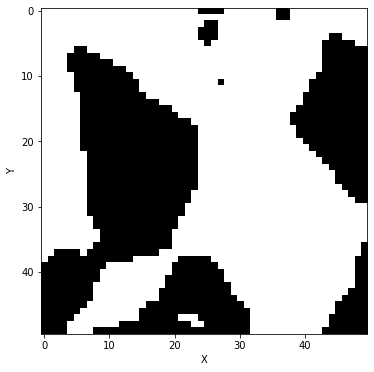

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel("X")
ax.set_ylabel("Y")
print(f'total number of training data: {len(train_data)}')
print(f'min of data: {torch.min(train_data[0])}')
print(f'max of data: {torch.max(train_data[0])}')
ax.imshow(train_data[0].reshape(50,50).detach().numpy(), cmap='gray')

## VAE Architecture

[sizing for hyperparameters](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)
$$
O = \frac{I - F + P_{\text{start}} + P_{\text{end}}}{S} + 1
$$

torch.nn.**Conv2d**(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

For rectangular image, with floor function

H(out)=⌊ [H(in)+2×padding[0]−dilation[0]×(kernel_size[0]−1)−1] / stride[0] + 1 ⌋

W(out)=⌊ [W(in)+2×padding[1]−dilation[1]×(kernel_size[1]−1)−1] / stride[1] + 1 ⌋

torch.nn.**ConvTranspose2d**(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)

For rectangular image,

H(out)=(H(in)−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

W(out)=(W(in)−1)×stride[1]−2×padding[1]+dilation[1]×(kernel_size[1]−1)+output_padding[1]+1

[expression for Kullback-Leibler divergence term](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)

[equivalent result when $\mathcal{N_1(\mu,\sigma)}$ and $\mathcal{N_2(0,1)}$](https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes?noredirect=1&lq=1)

In [49]:
# define encoder
class VariationalEncoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=16, latent_dim=50):
    super().__init__()

    self.net = nn.Sequential(
        # floor((50-3+1+1)/2 + 1) = 25
        nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1), # -> N, 16, 25, 25
        nn.ReLU(),
        # floor((25-3+1+1)/2 + 1) = 13
        nn.Conv2d(out_channels, 2*out_channels, 3, stride=2, padding=1), # -> N, 32, 13, 13
        nn.ReLU(),
        # floor((13-3+1+1)/2 + 1) = 7
        nn.Conv2d(2*out_channels, 4*out_channels, 3, stride=2, padding=1), # -> N, 64, 7, 7
        nn.ReLU(),
        # floor((7-7) + 1) = 1
        nn.Conv2d(4*out_channels, 4*out_channels, 7), # -> N, 64, 1, 1
        nn.ReLU(),
        nn.Flatten(),  # -> N, 64
        nn.Linear(4*out_channels, latent_dim),
        nn.ReLU()
    )
    self.linear1 = nn.Linear(latent_dim, latent_dim)
    self.linear2 = nn.Linear(latent_dim, latent_dim)
    self.N = torch.distributions.Normal(0, 1) # standard normal distribution
    self.Dkl = 0 # Kullback-Leibler divergence

  def forward(self, x):
    x = self.net(x) 
    mu = self.linear1(x) # mean
    sigma = torch.exp(self.linear2(x))
    z = mu + sigma*self.N.sample(mu.shape)
    self.Dkl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 0.5).sum()
    return z

# define decoder
class Decoder(nn.Module):
  def __init__(self, in_channels=1, out_channels=16, latent_dim=50):
    super().__init__()

    self.out_channels = out_channels

    self.linear = nn.Sequential(
        nn.Linear(latent_dim, 4*out_channels), # -> N, 64
        nn.ReLU()
    )

    self.conv = nn.Sequential(
        # (1-1)*1 + (7-1) + 1 = 7
        nn.ConvTranspose2d(4*out_channels, 4*out_channels, 7), # -> N, 64, 7, 7
        nn.ReLU(),
        # (7-1)*2-1-1 + (3-1) + 1 = 13
        nn.ConvTranspose2d(4*out_channels, 2*out_channels, 3, stride=2, padding=1), # -> N, 32, 13, 13
        nn.ReLU(),
        # (13-1)*2-1-1 + (3-1) + 1 = 25
        nn.ConvTranspose2d(2*out_channels, out_channels, 3, stride=2, padding=1), # -> N, 16, 25, 25
        nn.ReLU(),
        # (25-1)*2-1-1 + (3-1) + 1 + 1 = 50
        nn.ConvTranspose2d(out_channels, in_channels, 3, stride=2, padding=1, output_padding=1), # -> N, 1, 50, 50
        nn.Sigmoid() # since min=0. max=1.
    )

  def forward(self, x):
    output = self.linear(x)
    output = output.view(-1, 4*self.out_channels, 1, 1)
    output = self.conv(output)
    return output

# define autoencoder
class VariationalAutoencoder(nn.Module):
  def __init__(self, variational_encoder, decoder):
    super().__init__()
    self.encoder = variational_encoder
    self.encoder.to(device)

    self.decoder = decoder
    self.decoder.to(device)

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [54]:
latent_dim = 5
model = VariationalAutoencoder(VariationalEncoder(latent_dim=latent_dim), Decoder(latent_dim=latent_dim))
model

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
      (7): ReLU()
      (8): Flatten(start_dim=1, end_dim=-1)
      (9): Linear(in_features=64, out_features=5, bias=True)
      (10): ReLU()
    )
    (linear1): Linear(in_features=5, out_features=5, bias=True)
    (linear2): Linear(in_features=5, out_features=5, bias=True)
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=5, out_features=64, bias=True)
      (1): ReLU()
    )
    (conv): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
      (1): ReLU()
      (2): ConvTranspose2d(64, 32, kernel_size=(3,

## Training

In [55]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
num_epochs = 100
best_loss = np.inf
best_states = None
loss_history = []

for epoch in range(num_epochs):
  model.train()
  train_losses = []
  for batch in train_loader:
    optimizer.zero_grad()
   
    img = batch.to(device) # img.shape = torch.Size([batch_size, 1, 50, 50])
    recon = model(img)
    loss = loss_fn(recon, img) + model.encoder.Dkl
    
    loss.backward()
    optimizer.step()

    train_losses.append( loss.detach().item() )

  epoch_loss = np.mean(train_losses)
  if epoch_loss < best_loss:
    best_loss = np.copy(epoch_loss)
    best_states = copy.deepcopy( model.state_dict() )
  # record loss history
  if (epoch+1) % 1 == 0: print("epoch {:4d}, training loss = {:1.5e}".format(epoch+1, epoch_loss))
  loss_history.append(epoch_loss)
  # adjust the learning rate
  sch.step()

# load the trained NN
model.eval()
model.load_state_dict(best_states)

epoch    1, training loss = 7.41769e+00
epoch    2, training loss = 3.36371e+00
epoch    3, training loss = 1.20248e+00
epoch    4, training loss = 3.59243e-01
epoch    5, training loss = 1.72623e-01
epoch    6, training loss = 1.60180e-01
epoch    7, training loss = 1.60226e-01
epoch    8, training loss = 1.59369e-01
epoch    9, training loss = 1.59058e-01
epoch   10, training loss = 1.58859e-01
epoch   11, training loss = 1.58680e-01
epoch   12, training loss = 1.59414e-01
epoch   13, training loss = 1.58593e-01
epoch   14, training loss = 1.58562e-01
epoch   15, training loss = 1.58524e-01
epoch   16, training loss = 1.58544e-01
epoch   17, training loss = 1.58848e-01
epoch   18, training loss = 1.58969e-01
epoch   19, training loss = 1.58573e-01
epoch   20, training loss = 1.58706e-01
epoch   21, training loss = 1.60972e-01
epoch   22, training loss = 1.58913e-01
epoch   23, training loss = 1.58583e-01
epoch   24, training loss = 1.58511e-01
epoch   25, training loss = 1.58456e-01


<All keys matched successfully>

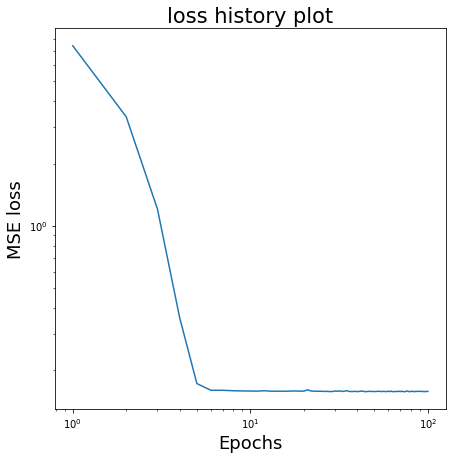

In [56]:
plt.figure(0,figsize=(7,7))
plt.loglog(np.arange(1,num_epochs+1), loss_history)
plt.title('loss history plot', fontsize=21)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('MSE loss', fontsize=18)
plt.show()

## Embedding

In [57]:
def plot_latent_2d(autoencoder, loader, z1=0, z2=1):
  '''
  plot z1-th and z2-th feature in the encoded feature vector z
  '''
  plt.figure(figsize=(6,6))
  plt.xlabel(f'X=z{z1}')
  plt.ylabel(f'Y=z{z2}')
  for batch in loader:
    z = autoencoder.encoder(batch.to(device))
    z = z.cpu().detach().numpy()  
    plt.scatter(z[:, z1], z[:, z2])

def plot_latent_boxwhisker(autoencoder, loader):
  '''
  plot the distribution of each embedded features, and
  return a vector of mean of each feature
  '''
  z_array = np.array([])
  for batch in loader:
    z = autoencoder.encoder(batch.to(device))
    z = z.cpu().detach().numpy() # -> N, latent_dim
    if z_array.shape[0]==0:
      z_array = z
    else:
      z_array = np.vstack((z_array, z))

  plt.figure(figsize=(12,6))
  #for i in range(z_array.shape[1]): # along the 2nd dimesion, i.e., number of features
  print(f'number of training samples: {z_array.shape[0]}')
  print(f'number of features: {z_array.shape[1]}')
  plt.boxplot(z_array)
  return np.mean(z_array, axis=0)

def plot_reconstructed(autoencoder, z, z1=0, z2=1, r0=(5, 20), r1=(5, 20), n=5):
  '''
  generate image from given encoded feature vector z with
  altering feature z1 and z2
  '''
  w = 50 # pixel width
  img = np.zeros((n*w, n*w))
  for i, y in enumerate(np.linspace(*r1, n)):
    for j, x in enumerate(np.linspace(*r0, n)):
      z[0] = x
      z[1] = y
      z = torch.tensor(z, dtype=torch.float32).to(device)
      x_hat = autoencoder.decoder(z)
      x_hat = x_hat.reshape(50, 50).cpu().detach().numpy()
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
  plt.figure(figsize=(6,6))
  plt.xlabel(f'X=z{z1}')
  plt.ylabel(f'Y=z{z2}')
  plt.gray()
  plt.imshow(img, extent=[*r0, *r1])

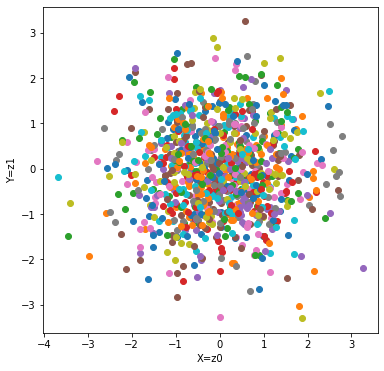

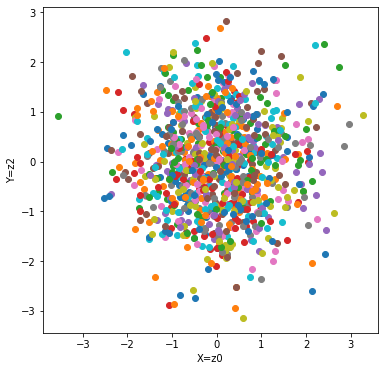

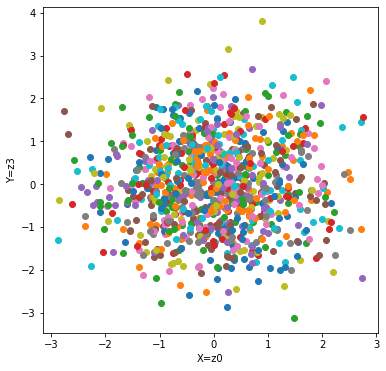

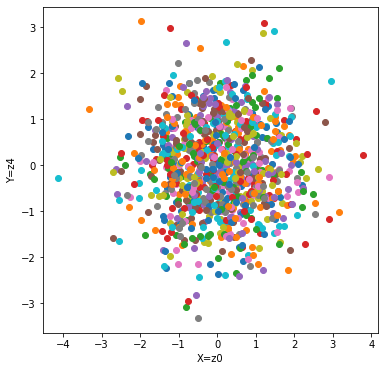

In [58]:
plot_latent_2d(model, train_loader, z1=0, z2=1)
plot_latent_2d(model, train_loader, z1=0, z2=2)
plot_latent_2d(model, train_loader, z1=0, z2=3)
plot_latent_2d(model, train_loader, z1=0, z2=4)

number of training samples: 1000
number of features: 5


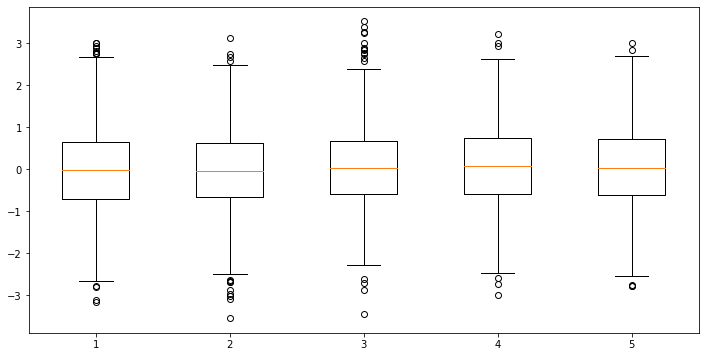

In [59]:
mean_embedding = plot_latent_boxwhisker(model, train_loader)

<ipython-input-57-dac4d61af700>:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z, dtype=torch.float32).to(device)


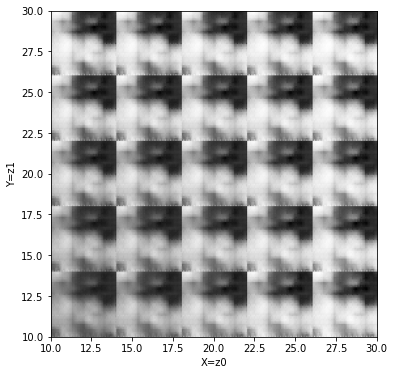

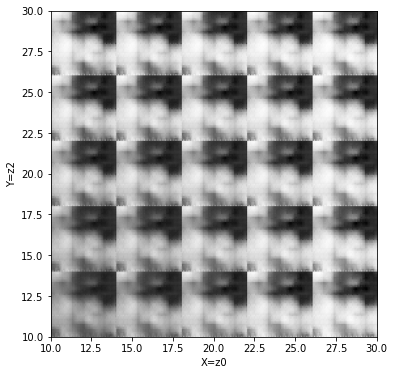

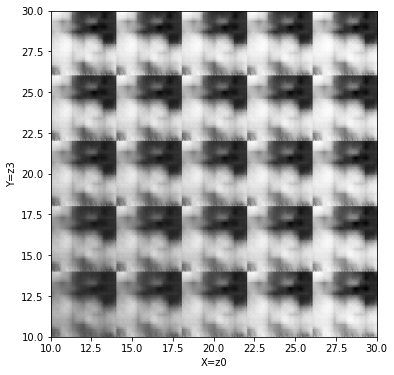

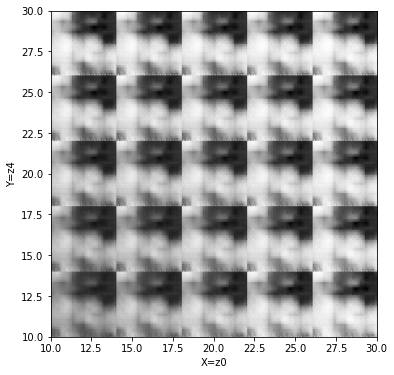

In [60]:
plot_reconstructed(model, mean_embedding, z1=0, z2=1, r0=(10, 30), r1=(10, 30))
plot_reconstructed(model, mean_embedding, z1=0, z2=2, r0=(10, 30), r1=(10, 30))
plot_reconstructed(model, mean_embedding, z1=0, z2=3, r0=(10, 30), r1=(10, 30))
plot_reconstructed(model, mean_embedding, z1=0, z2=4, r0=(10, 30), r1=(10, 30))

## Testing

In [63]:
test_img = []
test_recon = []
for batch in test_loader: # one per batch
  img = batch.to(device)  
  recon = model(img)
  test_img.append( img.cpu().detach().numpy() )
  test_recon.append( recon.cpu().detach().numpy() )

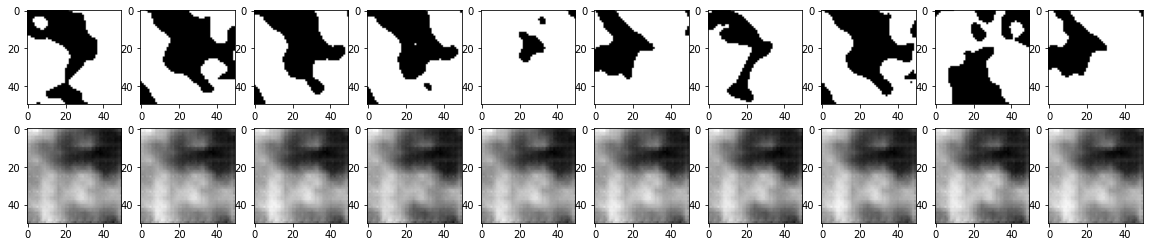

In [64]:
# randonly select 10 testing cases
idx = np.random.randint(0, len(test_data), 10)
#idx = range(10)
plt.figure(figsize=(20,4))
plt.gray()
for k in range(10):
  plt.subplot(2,10,k+1) # first line
  plt.imshow(test_img[idx[k]].reshape(50, 50))
  
  plt.subplot(2,10,10+k+1) # second line
  plt.imshow(test_recon[idx[k]].reshape(50, 50))